# Semantic Segmentation Tutorial

### ENEL 645 - Winter 2023
### Group #5
### Submission Date: March 6, 2023  

### Group Members and Contributions:

| **Name**       | **Student ID** | **Contribution**                                              | **Score** |
| -------------- | -------------- | ----------------                                              | --------- |
| Justin Nguyen  | 30042258       | Training Own Model, Initial Idea Research and Tutorial Draft  | 3         |
| Khoi Nguyen    | 10171399       | Using Pre-trained Model, Dataset Downloading                  | 3         |
| Feras Dahrooge | 30023852       | Training Own Model, Tutorial formatting and organization      | 3         |
| Seho Chung     | 10127744       | Training Own Model, Colab runs using best model               | 3         |
| Ardit Baboci   | 10149781       | Using Pre-trained Model, Initial model training               | 3         |

## Introduction

Semantic segmentation is the process of assigning a class label to each pixel in an image. In other words, it is a classification task done on a pixel-by-pixel basis. This is particularily useful in separating certain elements from the background, as is shown in the example below:

![Example Semantic Segmentatio of a Dog](images/dog-semantic-segmentation-example.png)

Some practical applications for this technology include:
- self-driving technology
- medical imaging
- augmented reality

Typical semantic segmentation architectures follow an encoder-decoder pattern, where the encoders compress the information into lower-dimensional representations, and the decoders project this information back to the original image dimensions. This tutorial will begin by using a pre-trained model from the PyTorch library, followed by training a semantic segmentation model using the segmentation-models-pytorch library.

## Section I: Using a Pre-Trained PyTorch Model
Based on examples at https://pytorch.org/

### 1. Import Libraries:

In [1]:
# !pip uninstall segmentation_models_pytorch timm pretrainedmodels efficientnet_pytorch
# !pip install segmentation_models_pytorch timm pretrainedmodels efficientnet_pytorch

import torch
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

import torchvision.transforms.functional as F

from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

c:\Users\justi\miniconda3\envs\pydml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Define a Helper Function and a color map:

In [2]:
# Display an array of images side-by-side
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
# Define a colour map so we can easily change the mask colour for each class later on   
color_map = [
               (0, 0, 0),  # background
               (128, 0, 0), # aeroplane
               (0, 128, 0), # bicycle
               (128, 128, 0), # bird
               (0, 0, 128), # boat
               (128, 0, 128), # bottle
               (0, 128, 128), # bus 
               (128, 128, 128), # car
               (64, 0, 0), # cat
               (192, 0, 0), # chair
               (64, 128, 0), # cow
               (192, 128, 0), # dining table
               (64, 0, 128), # dog
               (192, 0, 128), # horse
               (64, 128, 128), # motorbike
               (192, 128, 128), # person
               (0, 64, 0), # potted plant
               (128, 64, 0), # sheep
               (0, 192, 0), # sofa
               (128, 192, 0), # train
               (0, 64, 128) # tv/monitor
]

### 3. Load in and view a few example images

Below are some of the example images we'll be working with: 


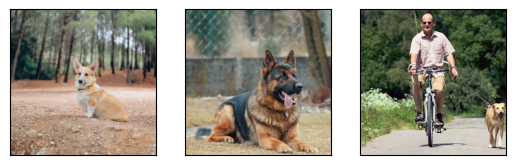

In [3]:
img1 = read_image(str(Path('images/input_samples') / 'img1.jpg'))
img2 = read_image(str(Path('images/input_samples') / 'img2.jpg'))
img3 = F.center_crop(read_image(str(Path('images/input_samples') / 'img3.jpg')), output_size=[500])

images = [img1, img2, img3]
print("Below are some of the example images we'll be working with: ")
show(images)

### 4. Initialize the Model with the Best Available Weights

For this tutorial, we'll be using a deeplabv3_resnet50 model which comes pre-built in PyTorch. This state-of-the-art model has been developed by Google reserachers 

In [4]:
from torchvision.io.image import read_image
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.transforms.functional import to_pil_image

weights = DeepLabV3_ResNet50_Weights.DEFAULT # DEFAULT => use best available
model = deeplabv3_resnet50(weights=weights) # initalize the model
model.eval() # toggle to evaluation/testing mode

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### 5. Create a pre-processing pipeline

To ensure that the inputs to the model are similar to the images on which the model was trained, the images must be pre-processed. Fortunately, PyTorch directly provides the required transformations for their built-in models.

In [5]:
# PyTorch includes the transformations with the weights for each model for convenice
preprocess = weights.transforms(resize_size=None)

# Pre-process each of the images in the list
batch = torch.stack([preprocess(img) for img in images])

### 6. Use the model and visualize the predictions

In [6]:
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([3, 21, 500, 500]) -5.559992790222168 14.352499961853027


In [7]:
# The output of the model is a tensor of shape (batch_size, num_classes, height, width).
# The 21 classes that the model has been trained on can also be printed

# Notice that the colour map defined earlier on corresponds to each of these classes
weights.meta["categories"]

['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [8]:
# First, we will enumerate each class using a dictionary
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

print(sem_class_to_idx)

{'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


In [9]:
# Since the values are not normalized, the next step is to normalize them into the range [0, 1] using softmax. 
# The values can then be interpreted as probabilities.
normalized_masks = torch.nn.functional.softmax(output, dim=1)

In [10]:
print(normalized_masks.shape)

torch.Size([3, 21, 500, 500])


shape = torch.Size([21, 3, 500, 500]), dtype = torch.bool


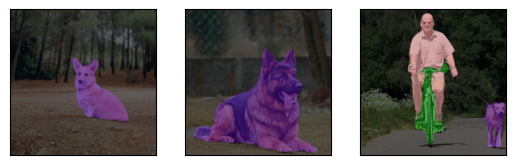

In [11]:
# Next, we want to plot the masks ontop of the original images
# The draw_segmentation_masks util can be used for this purpose
from torchvision.utils import draw_segmentation_masks

num_classes = normalized_masks.shape[1] # corresponds to 21, the number of classes
masks = normalized_masks[0] 
class_dim = 1 # the dimension corresponding to the number of classes

# Since the draw_segmentation_masks function expects the masks to be boolean, the masks must first be converted
all_classes_masks = normalized_masks.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
print(f"shape = {all_classes_masks.shape}, dtype = {all_classes_masks.dtype}")

# The first dimension is the classes now, so we need to swap it
all_classes_masks = all_classes_masks.swapaxes(0, 1)

images_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=.6, colors=color_map)
    for img, mask in zip(images, all_classes_masks)
]

show(images_with_masks)

As is shown above, our example images have been successfully segmented. The colours correspond to the the color_map that was defined earlier.

## Section II: Training a Semantic Segmentation Model
Now that we've seen how a semantic segmentation model can be used, we will be training a model. For this exercise, the semantic_model_pytorch library will be used which provides various architectures for multi-class segmentation. The Unet architecture will be used in this example.

Based on examples at https://segmentation-modelspytorch.readthedocs.io/en/latest/

### Step 1: Loading the Dataset

In [12]:
import os

# The data has been provided in this repo
DATA_PATH = './images/CamVid/'

x_train_dir = os.path.join(DATA_PATH, 'train')
y_train_dir = os.path.join(DATA_PATH, 'trainmask')

x_val_dir = os.path.join(DATA_PATH, 'val')
y_val_dir = os.path.join(DATA_PATH, 'valmask')

x_test_dir = os.path.join(DATA_PATH, 'test')
y_test_dir = os.path.join(DATA_PATH, 'testmask')

# Defining utility function
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Step 2: Define the DataLoader

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
import cv2

In [14]:
class CamVidDataset(Dataset):
   
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, # images path
            masks_dir, # masks path
            classes=None, # list of classes we want to extract
            augmentation=None, # data transformations
            preprocessing=None, # shape manipulation and normalization
    ):
        
        # Get the file names
        self.ids = os.listdir(images_dir)
        
        # filepaths for each image and mask
        self.images_paths = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_paths = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # encode string names to corresponding mask value
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read image
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # image read in BGR order so convert back
        
        # read the mask
        mask = cv2.imread(self.masks_paths[i], 0)
        
        # extract the specified classes
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

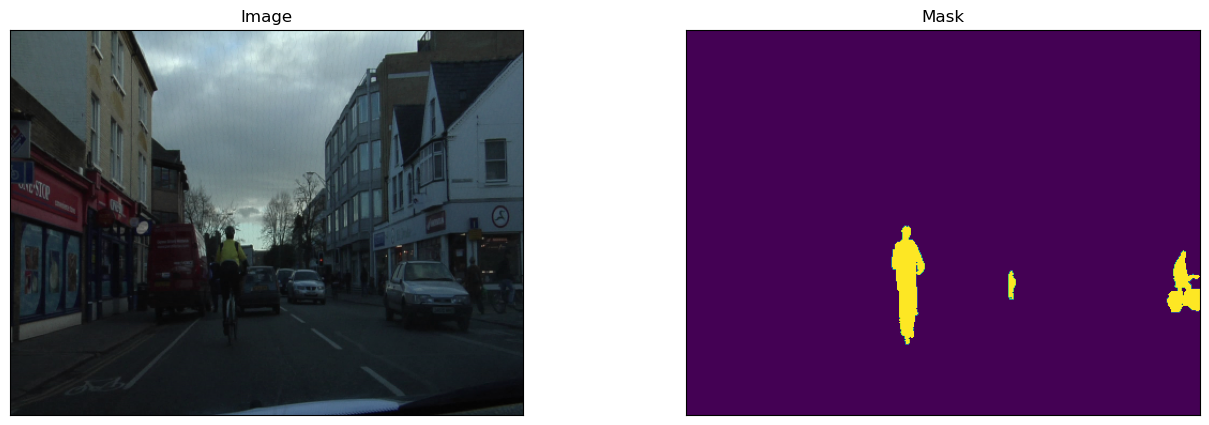

In [15]:
# Visualizing what we have so far with an example of bicyclists
dataset = CamVidDataset(x_train_dir, y_train_dir, classes=['bicyclist'])

image, mask = dataset[55] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

### Step 3: Apply Augmentations / Transformations
Since this dataset is fairly small (367 training images) and the images are similar in nature as a result of the dataset being a collection of frames extracted from only several videos, data augmentation will be applied to increase the size of the dataset and to prevent overfitting. The Albumentations library will be used for this purpose.

In [16]:
import albumentations as A

def training_augmentation():
    train_transform = [
        # p in the below is the probability of applying the augmentation
        
        # Pad and crop the image to 320x320
        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),
        
        # Flip image
        A.HorizontalFlip(p=0.5),

        # Add noise
        A.GaussNoise(p=0.2),
        A.Perspective(p=0.5),

        # Colour manipulations
        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    
    # create a pipeline from the transformations defined above
    return A.Compose(train_transform)


def validation_augmentation():
    # For validation, we only apply padding as needed
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def preprocessing(preprocessing_fn):
    # The smp library provides the preprocessing function based on the selected backbone
    # This will be used for preprocessing
    
    _transform = [
        # preprocess the images
        A.Lambda(image=preprocessing_fn),
        
        # convert to tensores
        A.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return A.Compose(_transform)

### Step 4: Define the Model

In [17]:
import torch_directml 

dml_device = torch_directml.device()
if torch.cuda.is_available():           # Check for NVIDIA gpu
    DEVICE = torch.device('cuda:0')
elif dml_device:                        # Check for AMD gpu
    DEVICE = dml_device
else:
    DEVICE = torch.device('cpu')
    
# if torch.backends.mps.is_available(): # Check for Apple Silicon gpu
#     DEVICE = torch.device('mps')
print(DEVICE)

ENCODER = 'resnet50' # use resnet50 similar to the PyTorch deeplabv3_resnet50 example above
ENCODER_WEIGHTS = 'imagenet' # resnet models were trained on imagenet
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
ACTIVATION = 'softmax2d' # for mutliclass segmentation use 'softmax2d'

# create baseline segmentation model
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
# Send the model to the device
model.to(DEVICE)

# the smp library provides the appropriate pre-processing pipeline based on the selected parameters
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

privateuseone:0


### Step 5: Define the DataLoaders

In [18]:
train_dataset = CamVidDataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=training_augmentation(), 
    preprocessing=preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = CamVidDataset(
    x_val_dir, 
    y_val_dir, 
    augmentation=validation_augmentation(), 
    preprocessing=preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

### Step 6: Define the Training Parameters

The intersection-over-union coefficeint (aka. Jaccard Index) is a commonly used metric for semantic segmentation tasks. This metric considers the overlap between the prediction and target as compared to the total number of pixels covered by the prediction and target as shown in the image below (Source: Wikipedia).

![intersection-over-union coefficeint](images/IoU.webp)

This is the metric which will be used in training our model below.

In [19]:
NEPOCHS = 40 # train using only 40 epochs in the interest of time for this tutorial

loss = smp.utils.losses.DiceLoss() # This is the same as F1 Score

metrics = [
    smp.utils.metrics.IoU(threshold=0.5), # Use IoU as explained above
]

optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [20]:
# Use smp utility functions to run each training and validation epoch
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

### Step 7: Train the Model

In [21]:
max_iou = 0
for i in range(0, NEPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # Save best model
    if max_iou < valid_logs['iou_score']:
        max_iou = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    # Reduce the learning rate after on epoch 25
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5


Epoch: 0
train:   2%|▏         | 1/46 [00:03<02:30,  3.35s/it, dice_loss - 0.9056, iou_score - 0.002725]


KeyboardInterrupt: 

### Step 8: Evaluate the Best Model 

In [22]:
best_model = torch.load('./best_model.pth')
best_model.to(DEVICE)

# Create the test dataset
test_dataset = CamVidDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=validation_augmentation(), 
    preprocessing=preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [23]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [00:15<00:00, 15.11it/s, dice_loss - 0.1595, iou_score - 0.7464]


The best model performed with an IoU of just over 75% on the test set. According to a 2020 survey paper (Image Segmentation Using Deep Learning: A Survey - https://arxiv.org/pdf/2001.05566.pdf), DeeplabV3 achieved over 85% on the VOC dataset, and more modern models have achieved over 90%. Even though the VOC dataset is different from the CamVid dataset used in this example (and arguably more difficult since it has many more classes), the numbers still serve as a good point of reference.

### Step 9: Use the Best Model For Predictions

In [24]:
# Load the test dataset without transformations for comparison purposes
test_dataset_no_transform = CamVidDataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

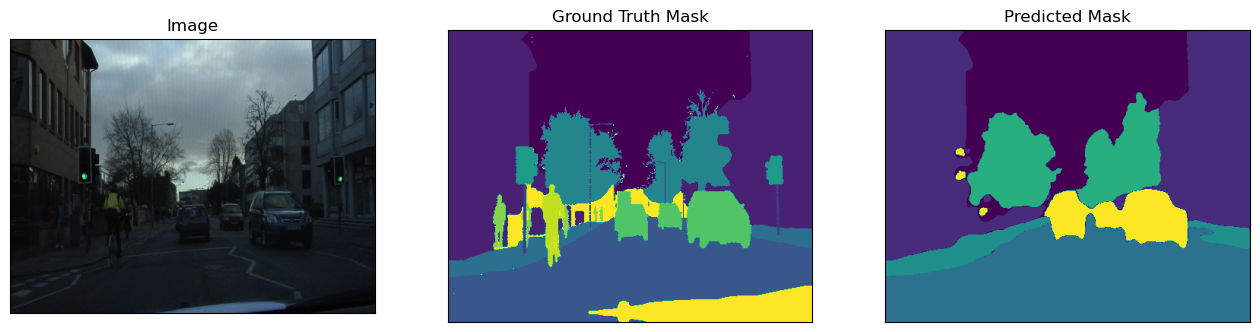

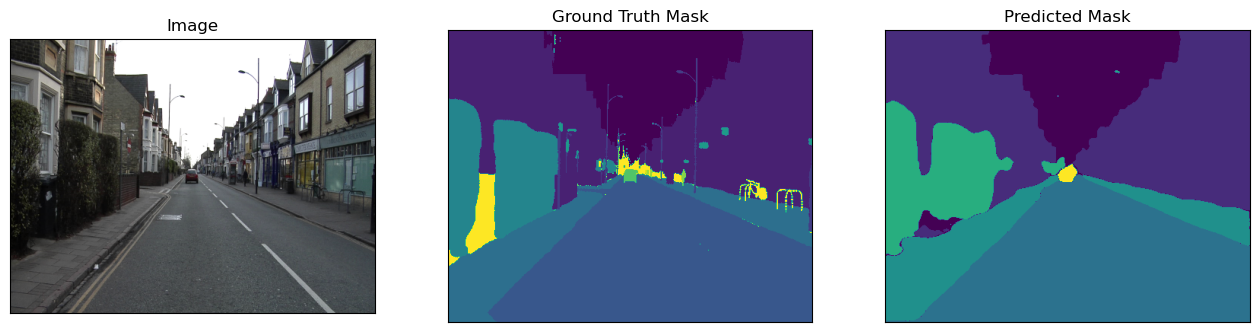

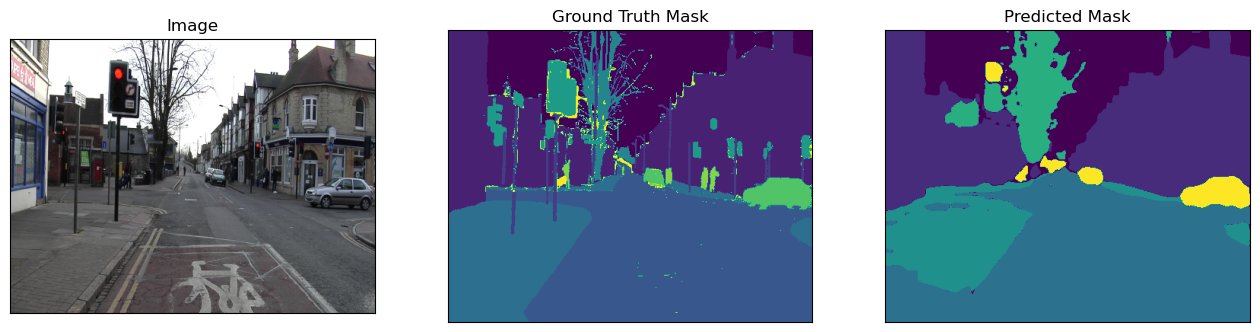

In [25]:
# Choose three images from the test set to predict
for i in [0, 79, 150]:
    image_no_transform = test_dataset_no_transform[i][0].astype('uint8')
    image, ground_truth_mask = test_dataset[i]
    
    ground_truth_mask = ground_truth_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

    # Predict the mask
    predicted_mask = best_model.predict(x_tensor)
    predicted_mask = (predicted_mask.squeeze().cpu().numpy().round())

    # Since the mask has 12 channels (one per class), combine them all into one
    # Multiply by i * 255/12 so each class mapping has a different value
    for i, mask in enumerate(ground_truth_mask):
        ground_truth_mask[i] = mask * i * 255/12

    for i, mask in enumerate(predicted_mask):
        predicted_mask[i] = mask * i * 255/12
        
    visualize(
        image=image_no_transform, 
        # Stack up the different layers so we can visualize it in one image
        ground_truth_mask=np.stack(ground_truth_mask, axis = -1).sum(axis=2), 
        predicted_mask=np.stack(predicted_mask, axis = -1).sum(axis=2)
    )

## Next Steps  
The natural progression from semantic segmentation on images is semantic segmentation on videos. The simplest approach for this task would be to consider each frame of the video as an image, and perform the task of image semantic segmentation on each of those frames. Combining the frames together would result in a semantically segmented video.

However, state-of-the-art models also take into consideration past frames when trying to determine the segmentation map for the current frame. This temporal element adds a whole other level of complexity. Various papers discussing this task are discussed here: https://paperswithcode.com/sota/video-semantic-segmentation-on-cityscapes-val.

## Section III: Semantic Segmentation on Videos

In this section, we will add semantic segmentation for videos, specifically for an mp4 video captured from a webcam with a person in it. We will then modify the background behind the person.

### Step 1: Load and Process the Video
We need to load the video and process it frame by frame using OpenCV. We will create a function called process_video that takes a video file as input and applies the semantic segmentation model to each frame.

In [26]:
def process_video(input_file, output_file, best_model, device):
    cap = cv2.VideoCapture(input_file)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Resize the frame to match the required dimensions
        resized_frame = cv2.resize(frame, (1280, 736))

        # Normalize the frame
        image = resized_frame.astype(np.float32) / 255.0
        image = image.transpose(2, 0, 1)

        # Convert the frame to a torch tensor
        x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)

        # Predict the mask
        predicted_mask = best_model.predict(x_tensor)
        predicted_mask = (predicted_mask.squeeze().cpu().numpy().round())

        # Combine the predicted mask layers
        for i, mask in enumerate(predicted_mask):
            predicted_mask[i] = mask * i * 255/12

        # Stack up the predicted mask layers and sum them
        combined_mask = np.stack(predicted_mask, axis=-1).sum(axis=2).astype(np.uint8)

        # Apply the colormap to the combined mask
        color_mask = cv2.applyColorMap(combined_mask, cv2.COLORMAP_JET)

        # Resize the color mask back to the original frame size
        color_mask = cv2.resize(color_mask, (width, height), interpolation=cv2.INTER_NEAREST)

        # Combine the original frame and the color mask
        output_frame = cv2.addWeighted(frame, 1, color_mask, 0.5, 0)

        # Write the frame
        out.write(output_frame)

    # Release the resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()


### Step 3: Process the Video with the Best Model
Now, we can use the process_video function to process a video file (e.g., 'input_video.mp4') and create a new video file with the background changed (e.g., 'output_video.mp4').

In [55]:
input_video = 'input_video.mp4'
output_video = 'output_video.mp4'

process_video(input_video, output_video, best_model, DEVICE)